# 🏠🏠House Rent Prediction 🏠🏠

## 📋 เกี่ยวกับชุดข้อมูล
ใช้ชุดข้อมูลจากเว็บไซต์ Kaggle ซึ่งเกี่ยวกับข้อมูลที่อยู่อาศัยที่สามารถให้เช่าอยู่ได้ในประเทศอินเดีย [Linked to Kaggle website](https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset)

📑 ซึ่งในข้อมูลจะประกอบไปด้วย :
- `BHK`: จำนวนห้องนอนห้องนั่งเล่นเเละห้องครัวรวมกัน
- `Rent`: ค่าเช่าของห้อง
- `Size`: ขนาดของที่ห้อง (ตารางฟุต)
- `Floor`: ห้องที่สามารถเช่าได้อยู่ชั้นใดของที่อยู่อาศัยเเละมีทั้งหมดกี่ชั้น (เช่น :ชั้นล่างสุดจากทั้งหมด 2 ชั้น, ชั้น 3 จากทั้งหมด 5)
- `Area Type`: ขนาดพื้นที่คำนวนจาก (Carpet Area: พื้นที่สามารถปูพรมได้), (ฺBuild Area: Carpet Area + พื้นที่กำเเพง), (Super Area: Build Area + พื้นที่ส่วนอื่นๆ
- `Area Locality`: ใกล้กับสถานที่ใดบ้าง
- `City`: ที่อยู่ของที่อยู่อาศัย
- `Furnishing Status`: สถานะเฟอร์นิเจอร์ในห้องเช่า (ไม่มีเฟอร์นิเจอร์ ,มีบ้างเล็กน้อย ,มีเฟอร์นิเจอร์) 
- `Tenant Preferred`: ประเภทของผู้เช่าที่เจ้าของอนุญาตให้เช่า
- `Bathroom`: จำนวนห้องน้ำ
- `Point of Contact`: บุคคลที่สามารถติดต่อสอบถามเพิ่มเติมได้เกี่ยวกับการเช่าที่อยู่อาศัย

# 📚 Import Library


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✏️ Define Functions & Read Dataset

In [87]:
def shape(df,df_name):
    print(f'ขนาดข้อมูลของ : "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f' จำนวนข้อมูลของ : "{column}"')
        display(vc_df)
def one_hot_encode(df, column):
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[column])
    # Drop column as it is now encoded
    df = df.drop(column,axis = 1)
    print(f"one hot encoded {column}")
    # Join the encoded df
    df = df.join(one_hot)
    return df
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("เเก้ไขชื่อคอลัมป์ทั้งหมดให้เป็นตัวพิมพ์เล็กเเละเเทนที่การเว้นวรรคด้วย underscore")
    print("ลบข้อมูลที่ซ้ำกันที่เป็นส่วนเกิน")
    return df
df = pd.read_csv("House_Rent_Dataset.csv")
shape(df,'df')
df.head()

ขนาดข้อมูลของ : "df" = (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


<br>

# 🧹 การ Clean ข้อมูล


In [88]:
# แก้ไขดัดแปลงข้อมูล.
shape(df,'df')
df2 = trim(df)
shape(df,'df')

# แก้ไขคอลัมป์ "floor"
df2 = df2.join(df2['floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))
df2['floor_level'] = df2.apply(lambda x: 0 if x['floor_level'] =='Ground' \
                               else ( -1 if x['floor_level'] =='Lower Basement' else (x['total_floor']) ) , axis=1)
print("\033[1mแก้ไขค่าในคอลัมป์ floor\033[0m : 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor")
df2.drop('floor',axis=1,inplace=True)

# ลบข้อมูลที่มีค่าเป็น NULL(N/A)
df2 = df2.dropna()
shape(df,'df')

# แก้ไข data type
df2['floor_level'] = df2['floor_level'].astype('int64')
df2['total_floor'] = df2['total_floor'].astype('int64')

df2['posted_on'] = pd.to_datetime(df2["posted_on"],errors='coerce')
display(df2.head())


ขนาดข้อมูลของ : "df" = (4746, 12)
เเก้ไขชื่อคอลัมป์ทั้งหมดให้เป็นตัวพิมพ์เล็กเเละเเทนที่การเว้นวรรคด้วย underscore
ลบข้อมูลที่ซ้ำกันที่เป็นส่วนเกิน
ขนาดข้อมูลของ : "df" = (4746, 12)
แก้ไขค่าในคอลัมป์ floor : 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor
ขนาดข้อมูลของ : "df" = (4746, 12)


C:\Users\picth\AppData\Local\Temp\ipykernel_8812\3368249499.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2 = df2.join(df2['floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))


,posted_on,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


In [89]:
df2.info()

# ตรวจสอบจำนวนของข้อมูลทั้งหมด
for col in df2.select_dtypes(include=['object']).columns:
    vc(df2, col)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4742 entries, 0 to 4745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   posted_on          4742 non-null   datetime64[ns]
 1   bhk                4742 non-null   int64         
 2   rent               4742 non-null   int64         
 3   size               4742 non-null   int64         
 4   area_type          4742 non-null   object        
 5   area_locality      4742 non-null   object        
 6   city               4742 non-null   object        
 7   furnishing_status  4742 non-null   object        
 8   tenant_preferred   4742 non-null   object        
 9   bathroom           4742 non-null   int64         
 10  point_of_contact   4742 non-null   object        
 11  floor_level        4742 non-null   int64         
 12  total_floor        4742 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 518.7+ 

,count,percentage (%)
area_type,,
Super Area,2444,51.539435
Carpet Area,2296,48.418389
Built Area,2,0.042176


 จำนวนข้อมูลของ : "area_locality"


,count,percentage (%)
area_locality,,
Bandra West,37,0.780261
Gachibowli,29,0.611556
Electronic City,24,0.506116
Velachery,22,0.463939
"Miyapur, NH 9",22,0.463939
...,...,...
Mandirtala,1,0.021088
"Mandakini Enclave, Alaknanda",1,0.021088
"DDA Akshardham Apartments, DS 19",1,0.021088


 จำนวนข้อมูลของ : "city"


,count,percentage (%)
city,,
Mumbai,972,20.497680
Chennai,891,18.789540
Bangalore,886,18.684100
Hyderabad,866,18.262337
Delhi,603,12.716154
Kolkata,524,11.050190


 จำนวนข้อมูลของ : "furnishing_status"


,count,percentage (%)
furnishing_status,,
Semi-Furnished,2250,47.448334
Unfurnished,1814,38.253901
Furnished,678,14.297765


 จำนวนข้อมูลของ : "tenant_preferred"


,count,percentage (%)
tenant_preferred,,
Bachelors/Family,3441,72.564319
Bachelors,830,17.503163
Family,471,9.932518


 จำนวนข้อมูลของ : "point_of_contact"


,count,percentage (%)
point_of_contact,,
Contact Owner,3212,67.735133
Contact Agent,1529,32.243779
Contact Builder,1,0.021088


In [90]:
# ตัดข้อมูลที่โดดออกมา (ข้อมูลที่มีค่าน้อยกว่าหรือมากกว่าข้อมูลทั่วไปมากๆ)
shape(df2,'df2')
df3 = df2[~df2['point_of_contact'].str.contains("Contact Builder")]
df3 = df3[~df3['area_type'].str.contains("Built Area")]
shape(df3,'df3')

area_locality_temp = vc(df3, 'area_locality',True)
area_locality_temp = area_locality_temp[area_locality_temp['count']==1]
print(f"Number of unique area_locality is {area_locality_temp.shape[0]} ")

# replace unique value to others
df3['area_locality'] = df3['area_locality'].replace(area_locality_temp.index, 'Others')
area_locality_temp = vc(df3, 'area_locality',True)

# extract date time
#df3['month_posted'] = df3['posted_on'].dt.month
#df3['day_posted'] = df3['posted_on'].dt.day
#df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
#df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
#df3['quarter_poster'] = df3['posted_on'].dt.quarter


# drop datetime
df3.drop('posted_on',axis=1,inplace=True)
df3.head()

ขนาดข้อมูลของ : "df2" = (4742, 13)
ขนาดข้อมูลของ : "df3" = (4739, 13)
Number of unique area_locality is 1461 


,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2,7500,850,Carpet Area,Others,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


# 2nd Choices

In [91]:
##Dropping unnecesaary columns from dataset
df = df.drop(['Posted On','Area Locality','Floor'],axis=1)
df.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [92]:
df = pd.get_dummies(df, columns=['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact'])
df.head()

,BHK,Rent,Size,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,City_Bangalore,City_Chennai,City_Delhi,...,City_Mumbai,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2,10000,1100,2,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,2,20000,800,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,2,17000,1000,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,2,10000,800,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,2,7500,850,1,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


<br>

# ⚙️การประมวลผลข้อมูล

 $\;\;\;\;\;$**4 ข้อที่ควรตวจสอบก่อนวิเคราะห์ Regression**
> 1. `Linearity` : ความสัมพันธ์ระหว่างตัวแปรอิสระ (X) กับตัวแปรตาม (Y) เป็นเส้นตรง
> 2. `Homoscedasticity` : ความแปรปรวนของความคลาดเคลื่อน (Residual) เท่ากันสำหรับทุกค่า X
> 3. `Independence` : ตัวแปรอิสระไม่เกี่ยวข้องกันมากเกินไป
> 4. `Normality` : การแจกแจงของตัวแปรตามเป็นแบบโค้งปกติ (Normal Distribution) ที่ทุกค่าของ X

จาก
> 1. `Linearity` : ความสัมพันธ์ระหว่างตัวแปรอิสระ (X) กับตัวแปรตาม (Y) เป็นเส้นตรง

เริ่มจาก Plot กราฟเพื่อตรวจสอบความสัมพันธ์ของเเต่ละตัวแปร

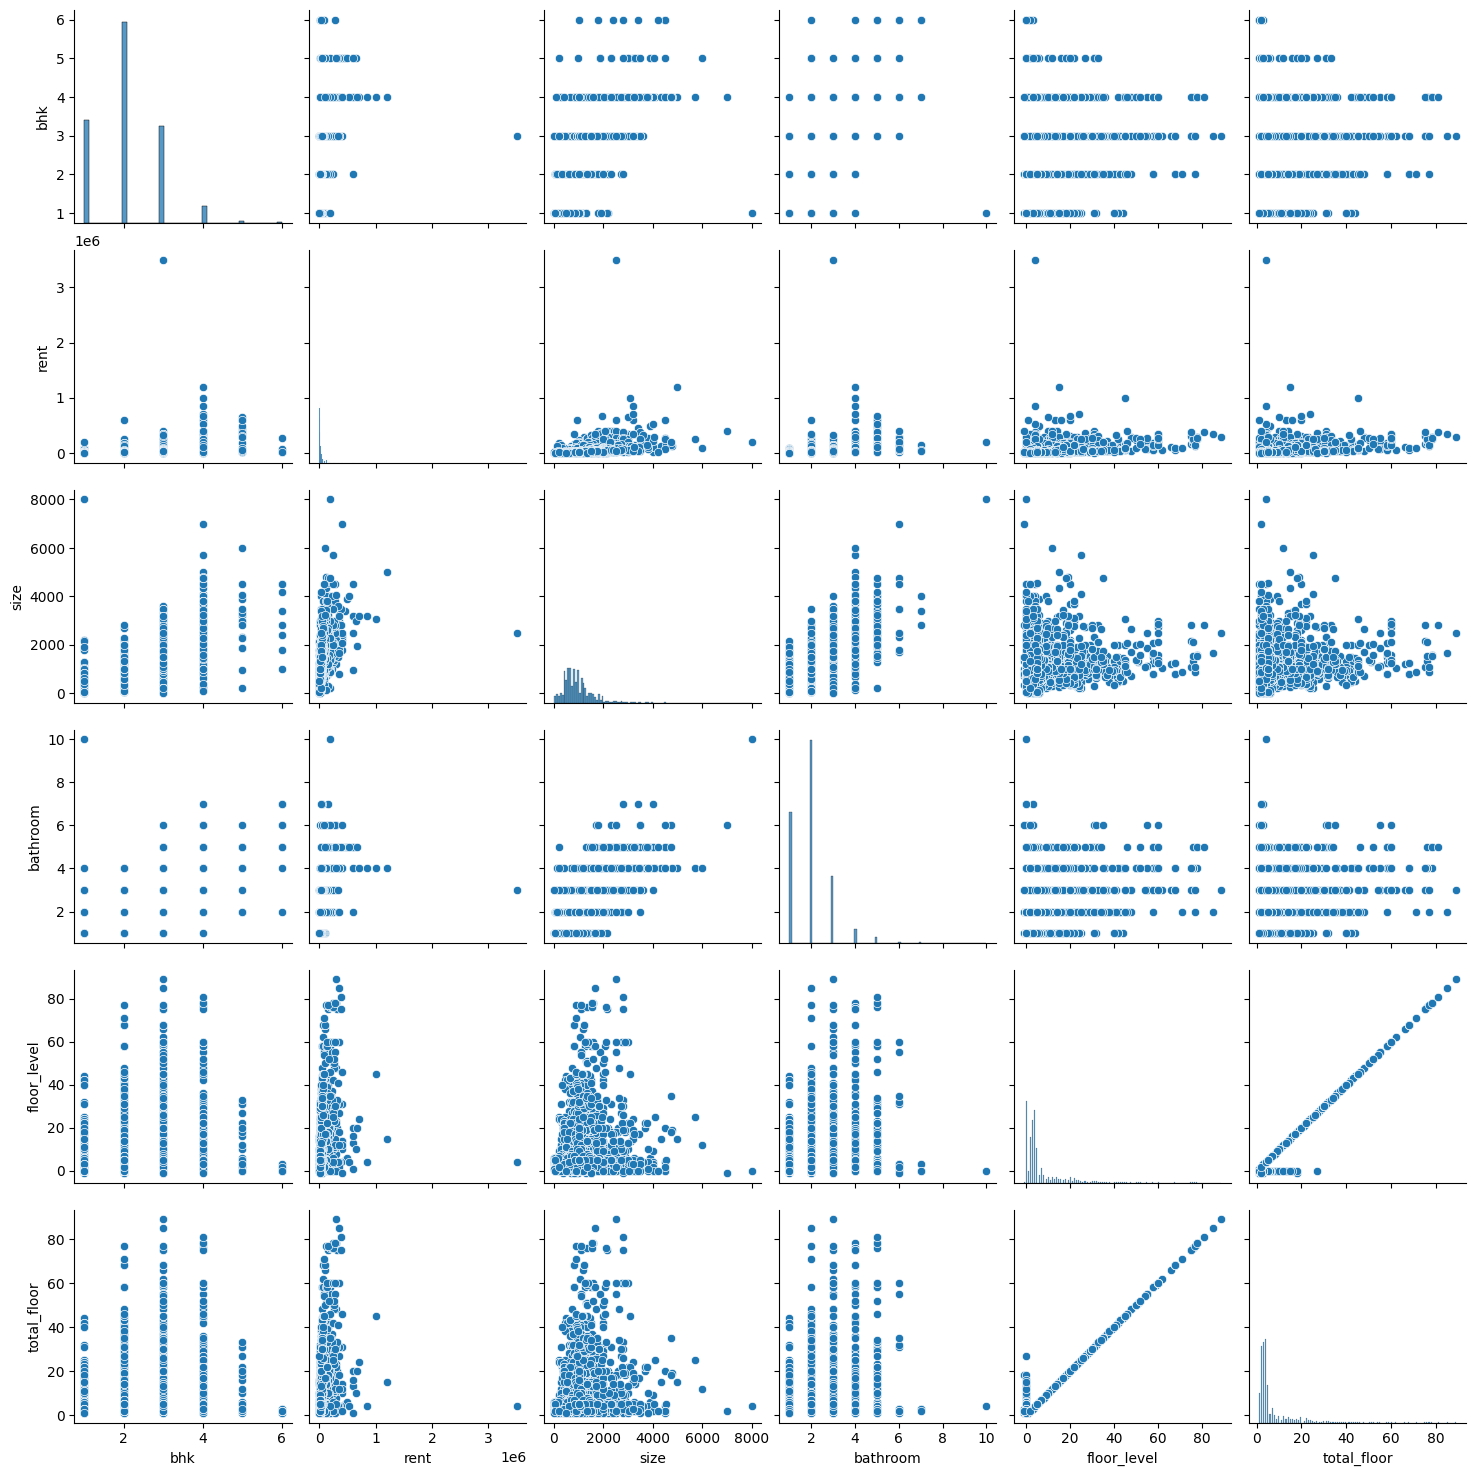

In [93]:
sns.pairplot(df3)

จาก
> 3\. `Independence` : ตัวแปรอิสระไม่เกี่ยวข้องกันมากเกินไป

ตรวจสอบความสัมพันธ์ของตัวแปรอิสระโดยใช้ Pearson's correlation  
<div>
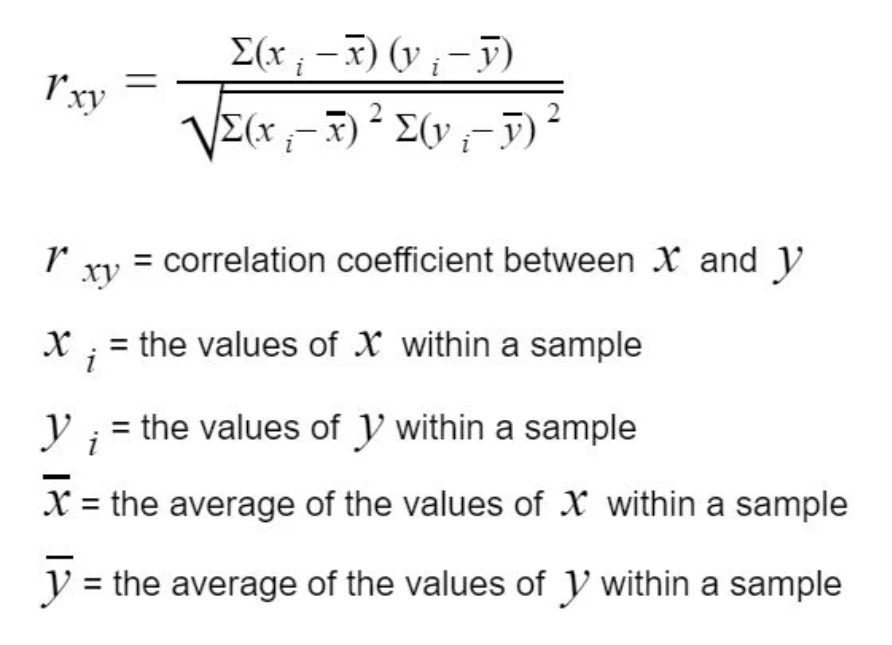
</div>

C:\Users\picth\AppData\Local\Temp\ipykernel_8812\113349208.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data=df3.corr(),  # our correlation matrix


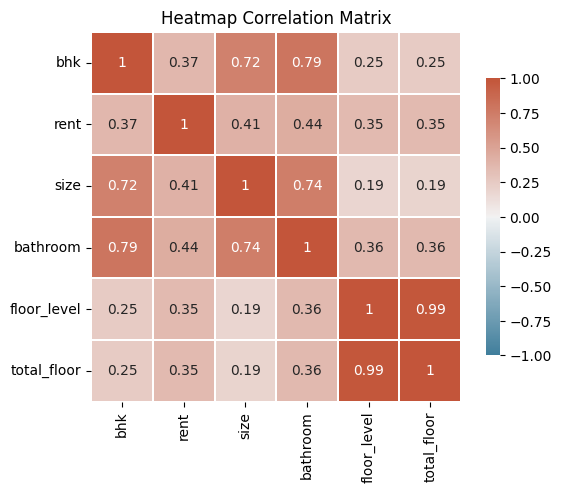

In [94]:
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=df3.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75},# shrink the scale a bit
        annot = True
)
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
plt.title(f'Heatmap Correlation Matrix')
# show the heatmap
plt.show()

จาก
> 4\. `Normality` : การแจกแจงของตัวแปรตามเป็นแบบโค้งปกติ (Normal Distribution) ที่ทุกค่าของ X

ตรวจสอบการแจกแจงของราคาเช่าบ้าน

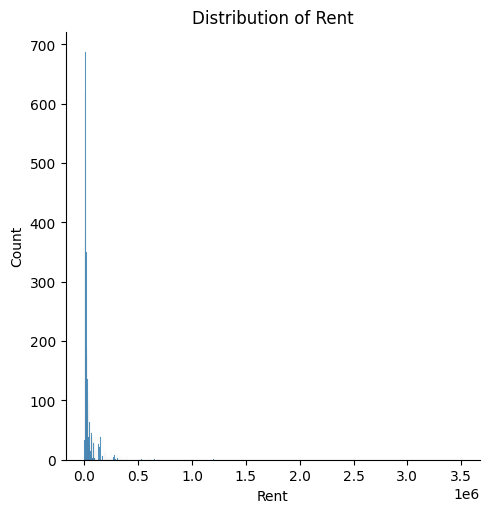

กราฟมีการกระจายตัวแบบโค้งเบ้ลาดขวา


In [95]:
def vis_dist(df, col, lim=False):
    variable = df[col].values
    ax = sns.displot(variable)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    if lim:
        plt.xlim(0, 4000)
    return plt.show()
vis_dist(df, 'Rent')
print("กราฟมีการกระจายตัวแบบโค้งเบ้ลาดขวา")

<br>
*เพื่อให้สะดวกต่อการดูการกระจายของข้อมูลที่ชัดขึ้น จึงลดสเกลของกราฟลง*

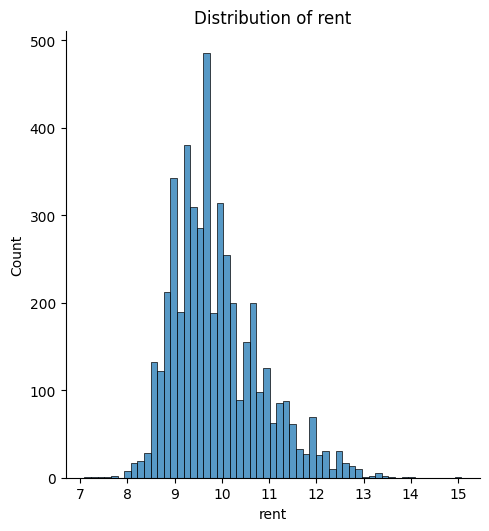

In [96]:
df3['rent'] = np.log1p(df3['rent'])
vis_dist(df3, 'rent')

# 🎓 Training a Linear Regression Model

สมการที่ใช้การทำนายของ Linear Regression คือ  
$$\hat{y} = θ_0x_0 + θ_1x_1 + θ_2x_2 + \ldots + θ_nx_n$$  
โดยที่  
$\hat{y}$: ค่าที่โมเดลทำนายออกมา  
$\theta$: model parameters  
$x$: feature value  
$n$: จำนวน feature ในชุดข้อมูล  
$x_0$: 1 (สำหรับการคูณ vector)  
$\theta_0$: Intercept

สังเกตว่าสมการนี้คือ dot product ระหว่าง θ กับ x จึงสามารถเขียนสมการใหม่ได้ออกมาเป็น
$$\hat{y} = \boldsymbol{x}^T \boldsymbol{\theta}$$

แต่ในการคำนวณจริง เราจำเป็นต้องคำนวณค่า $\hat{y}$ หลายตัวพร้อมกัน  
จึงให้ X เป็น matrix ที่มี $n$ แถวแทนจำนวนชุดข้อมูล และ $i$ คอลัมน์แทนจำนวน feature
$$
\begin{bmatrix}  
x_0^0  & \cdots & x_i^0  \\
\vdots & \ddots & \vdots \\
x_0^n  & \cdots & x_i^n  \\
\end{bmatrix}  
\begin{bmatrix}  
\theta_0 \\
\vdots   \\
\theta_i \\
\end{bmatrix} = 
\begin{bmatrix}  
\hat{y}_0 \\
\vdots  \\
\hat{y}_n \\
\end{bmatrix}  
$$
$$\boldsymbol{\hat{y}} = X\boldsymbol{\theta}$$

# 📌 กำหนดตัวแปรอิสระ X และตัวแปรตาม y

In [99]:
X = df.drop('Rent',axis=1)
y = df['Rent']